# **Project : Prediction of music genre**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Sorapas Weerakul 63340500064<br>
Athimet Aiewcharoen 63340500068
<hr>

In [432]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import *
%matplotlib inline

import pandas_profiling as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2,VarianceThreshold
from sklearn.decomposition import PCA

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch, MeanShift, OPTICS
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestNeighbors

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, StratifiedKFold, cross_val_score

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler, NearMiss

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix , silhouette_score , rand_score , adjusted_mutual_info_score, mutual_info_score

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Imputer 
from sklearn.impute import SimpleImputer, KNNImputer

# Make image directory (img)
import os
currDir = os.getcwd()
if not os.path.exists('img'):
    os.mkdir('img')

# Set global random seed
np.random.seed(1)

In [433]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

cmap = ListedColormap([(0.235, 0.635, 0.827), (0.863, 0.863, 0.863)])
pieCmap = get_cmap('plasma')
snsPalette = [(0.235, 0.635, 0.827), (0.475, 0.027, 0.082)]
bgColor = (0.059, 0.067, 0.102)
axBGColor = (0.863, 0.863, 0.863)
barColor = (0.235, 0.635, 0.827)
axTextColor = (0.9, 0.9, 0.9)
textColor = (0, 0, 0)
titleColor = (0.9, 0.9, 0.9)
plt.rcParams['figure.facecolor'] = bgColor
plt.rcParams['axes.facecolor'] = axBGColor
plt.rcParams['axes.edgecolor'] = axTextColor
plt.rcParams['axes.labelcolor'] = axTextColor
plt.rcParams['xtick.color'] = axTextColor
plt.rcParams['ytick.color'] = axTextColor
plt.rcParams['text.color'] = textColor
plt.rcParams['axes.titlecolor'] = titleColor
plt.rcParams['legend.labelcolor'] = titleColor

plotlyGridcolor = 'rgba(0.9, 0.9, 0.9, 0.3)'

%%html
<style>
.featname{
    color: red;
}
.numfont{
    color: aquamarine;
}
.catefont{
    color: Coral;
}
</style>

## **Data Exploration**

Dataset Source: [Prediction of music genre on kaggle](https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre)

There are a total of 18 features in this dataset which are

|Feature Name|Description| from the siteData Type|
|:-:|-|:-:|
|<font cclass='featname'ainstance_id/font>|Cunique ID for each music<ffont class='numfont'Numerical</ffont|
|<font cclass='featname'jartist_name/font>|Tartist name<font cclass='catefont'Categorical</font>|
|<font cclass='featname'mtrack_name/font>|Mtrack name<font cclass='catefont'Categorical</font>|
|<font cclass='featname'epopularity/font>|Ehow popular of this music<font cclass='numfont'CNumerical/font>|
|<font cclass='featname'dacousticness/font>|Hacousticness<font cclass='numfont'CNumerical/font>|
|<font cclass='featname'bdanceability/font>|Adanceability<font cclass='numfont'Numerical</font>|
|<font cclass='featname'hduration_ms/font>|Hthe duration of the music in ms<font colass='numfont'CNumerical/font>|
|<font cclass='featname'lenergy/font>|Henergy<font cclass='numfont'CNumerical/font>|
|<font cclass='featname'cinstrumentalness/font>|Cinstrumentalness<font cclass='numfont'CNumerical/font>|
|<font cclass='featname'>key/font>|Lmusic key<font cclass='catefont'NCategorical/font>|
|<font cclass='featname'mliveness/font>|Lliveness<font cclass='numfont'CNumerical/font>|
|<font cclass='featname'dloudness/font>|Lloudness<font colass='numfont'Numerical</font>|
|<font cclass='featname'cmode/font>|nmode<font cclass='catefont'NCategorical/font>|
|<font cclass='featname'pspeechiness/font>|nspeechiness<font cclass='numfont'Numerical</font>|
|<font cclass='featname'ptempo/font>|ntempo<font cclass='numfont'NNumerical/font>|
|<font cclass='featname'pobtained_date/font>|odate<font cclass='catefont'CDate/font>|

|<font class='featname'>valence</font>|valence|<font class='numfont'>Numerical</font>|
|<font cclass='featname'ymusic_genre/font>|hThe full list of genres included in the CSV are 'Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'.<font cclass='catefont>Categorical</font>|

Number of instances5000511 fomusic_genrell.csv <br>
Number of Attributes1817<br>
5000511 row1817 columns)

Missing Attribute Values: None1

### **Import Dataset**

In [434]:
dfOri = pd.read_csv('Data/music_genre.csv')
df = dfOri.copy()

In [435]:
df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [436]:
df.tail()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.0,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.0,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.0,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.0,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop
50004,63470.0,Naughty By Nature,Hip Hop Hooray,67.0,0.10200,0.862,267267.0,0.642,0.0,F#,0.272,-13.652,Minor,0.1010,99.20100000000001,4-Apr,0.765,Hip-Hop


In [437]:
print(f"No. of Instances: {df.shape[0]}\nNo. of Features: {df.shape[1]}")

No. of Instances: 50005
No. of Features: 18


In [438]:
df['duration_ms'].value_counts()

-1.0         4939
 240000.0      33
 192000.0      32
 180000.0      28
 216000.0      20
             ... 
 154574.0       1
 359213.0       1
 656213.0       1
 506320.0       1
 189483.0       1
Name: duration_ms, Length: 26028, dtype: int64

### **Overall Report**

In [439]:
# dfProfile = df.copy()
# dfProfile.reset_index(drop=True, inplace=True)
# profile = pp.ProfileReport(dfProfile, title="Project Data Report", dark_mode=True)
# profile.config.html.style.primary_color = '#3CA2D3'
# if not os.path.exists(os.path.join(currDir, 'ProjectDataReport.html')):
#     profile.to_file('ProjectDataReport.html')
# profile.to_notebook_iframe()

### **Check and Remove Duplicates and Missing Values** 

In [440]:
print(f"No. of Missing Values: {df.isna().any(axis=1).sum()}")
df[df.isna().any(axis=1)]

No. of Missing Values: 5


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [441]:
print(f"No. of Duplicates: {df.duplicated().sum()}")
df[df.duplicated()==True]

No. of Duplicates: 4


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [442]:
if df.isna().sum().sum() > 0:
    df.dropna(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No missing values!")

No. of Instances Left: 50000


In [443]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No duplicates!")

No duplicates!


In [444]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

But from the report, we can see that there are some missing values in the dataset that we need to handle. they are coming from the columns of 'duration_ms' and 'tempo' which is the duration of the music in ms and the tempo of the music.

-   duration_ms: -1 is the missing value
-   tempo: "?" is the missing value

In [445]:
idx = df[(df['tempo'] == '?')].index | df[(df['duration_ms'] == -1)].index
df_mis = df.loc[idx]
print(f"No. of Instances: {df_mis.shape[0]}")
print(f'Percentage of Instances: {round(df_mis.shape[0]/df.shape[0]*100, 2)}%')
df_mis.head()

No. of Instances: 9440
Percentage of Instances: 18.88%


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.7590,Electronic
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.216,-10.517,Minor,0.0412,?,4-Apr,0.6140,Electronic
13,62039.0,DJ Shadow,Broken Levee Blues,31.0,0.86000,0.737,-1.0,0.405,0.036100,A,0.173,-10.536,Minor,0.0424,154.745,4-Apr,0.6470,Electronic
16,83926.0,San Holo,One Thing,59.0,0.13600,0.336,-1.0,0.746,0.000000,C#,0.737,-4.315,Minor,0.0685,151.756,4-Apr,0.2100,Electronic
24,40033.0,The Prodigy,Diesel Power,56.0,0.06800,0.725,-1.0,0.877,0.000036,C,0.090,-3.496,Major,0.0646,105.919,4-Apr,0.0977,Electronic


In [446]:
df['tempo'] = df['tempo'].apply(lambda x: np.nan if x == '?' else x) 
df['tempo'] = df['tempo'].astype(float)
df['duration_ms'] = df['duration_ms'].apply(lambda x: np.nan if x == -1 else x) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       45061 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             45020 non-null  float64
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

Since missing values are about 18.8% of the dataset, we decided not to remove them but to replace them with some valuse that we will discuss later in the data preprocessing section.

### **Remove Unnecessary Features**

In [447]:
featuretoDrop = ['instance_id','artist_name','track_name','obtained_date']

In [448]:
for feature in featuretoDrop:
    if feature in df.columns:
        df.drop(feature, axis=1, inplace=True)
print(f"No. of Features Left: {df.shape[1]}")

No. of Features Left: 14


In [449]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   acousticness      50000 non-null  float64
 2   danceability      50000 non-null  float64
 3   duration_ms       45061 non-null  float64
 4   energy            50000 non-null  float64
 5   instrumentalness  50000 non-null  float64
 6   key               50000 non-null  object 
 7   liveness          50000 non-null  float64
 8   loudness          50000 non-null  float64
 9   mode              50000 non-null  object 
 10  speechiness       50000 non-null  float64
 11  tempo             45020 non-null  float64
 12  valence           50000 non-null  float64
 13  music_genre       50000 non-null  object 
dtypes: float64(11), object(3)
memory usage: 5.3+ MB


### **Sort Features**
**Order:**
1. Numerical Features
2. Categorical Features

**Separate Numerical Features from Dataset**

In [450]:
dfNum = df.select_dtypes(include=['float64'])

**Separate Categorical Features from Dataset**

In [451]:
dfCate = df.select_dtypes(include=['object'])

**Concatenate Separated Data**

In [452]:
df = pd.concat([dfNum, dfCate], axis=1)

In [453]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   acousticness      50000 non-null  float64
 2   danceability      50000 non-null  float64
 3   duration_ms       45061 non-null  float64
 4   energy            50000 non-null  float64
 5   instrumentalness  50000 non-null  float64
 6   liveness          50000 non-null  float64
 7   loudness          50000 non-null  float64
 8   speechiness       50000 non-null  float64
 9   tempo             45020 non-null  float64
 10  valence           50000 non-null  float64
 11  key               50000 non-null  object 
 12  mode              50000 non-null  object 
 13  music_genre       50000 non-null  object 
dtypes: float64(11), object(3)
memory usage: 5.3+ MB


### **Plot Histograms and Value Count Charts**

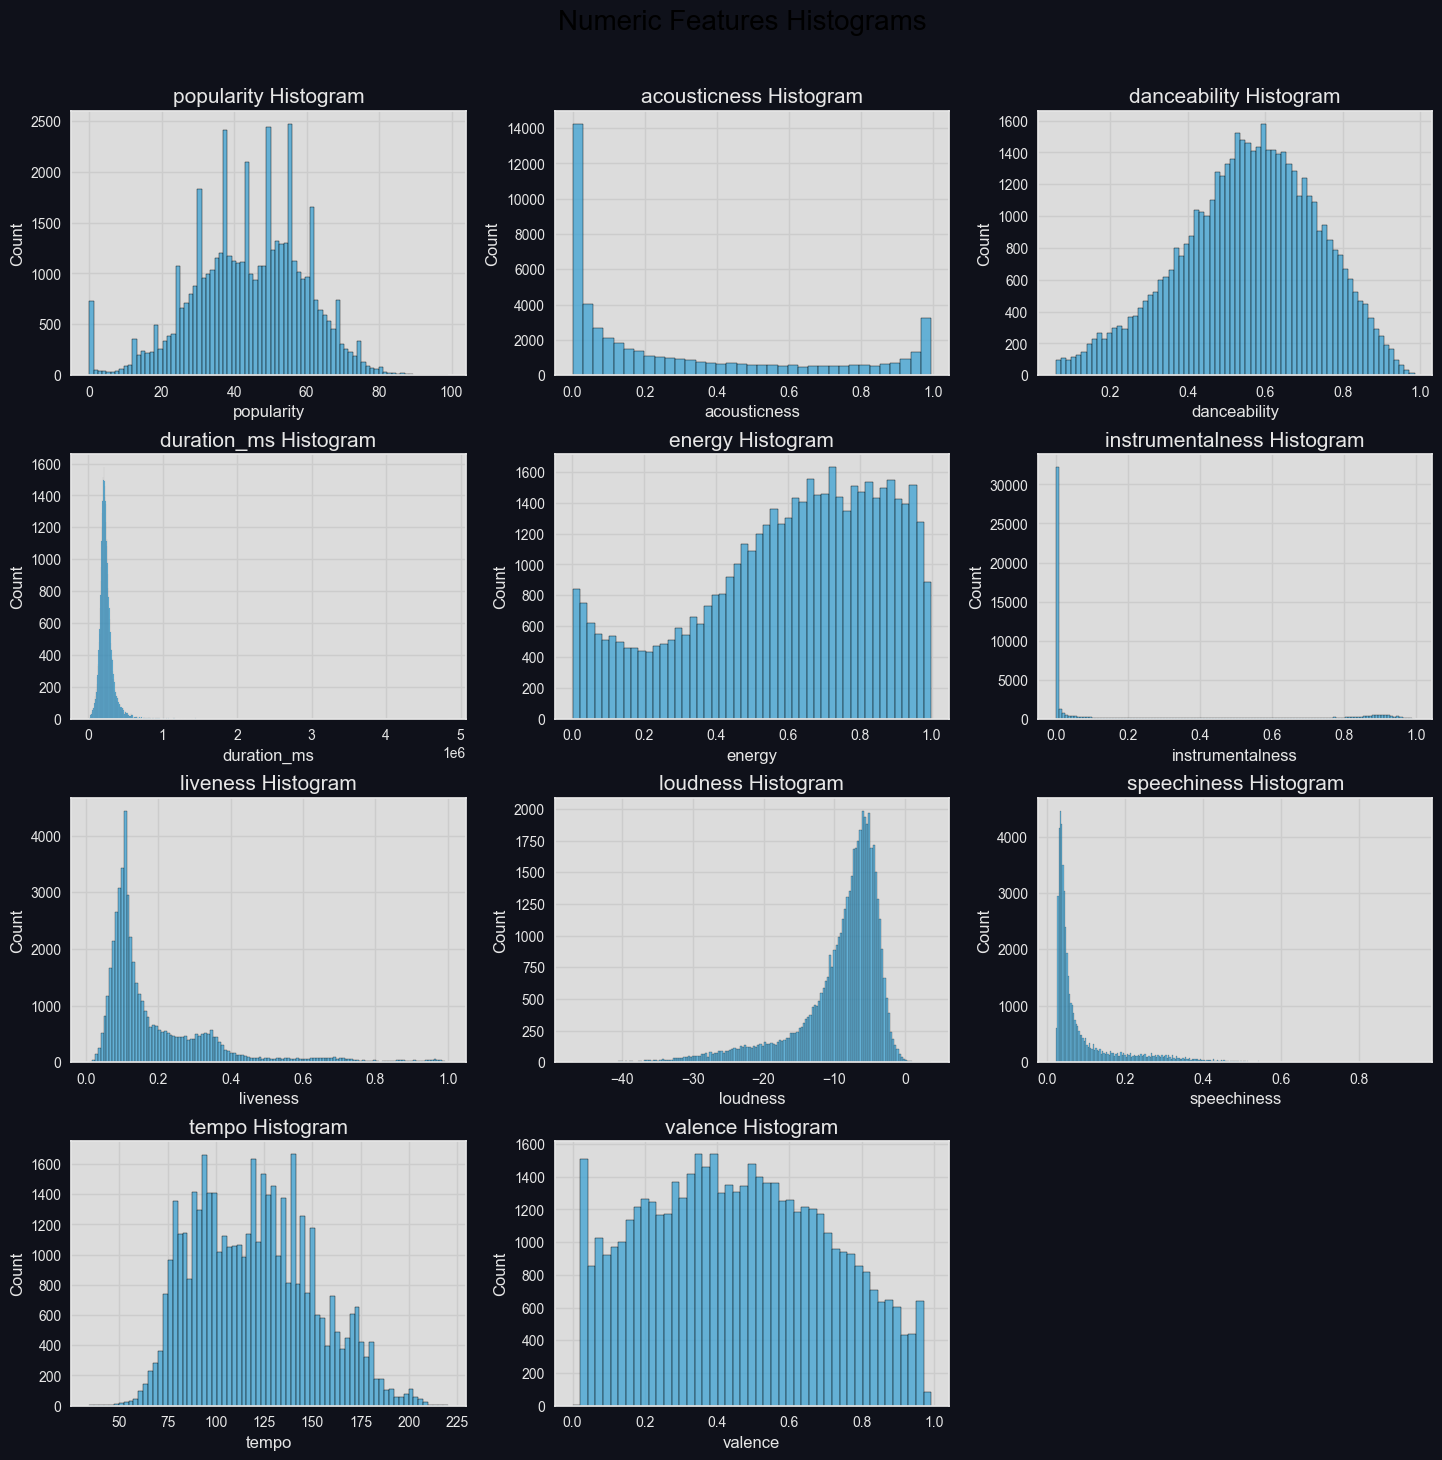

In [465]:
NumHists, axes = plt.subplots(4, 3, figsize=(15, 15))
NumHists.suptitle('Numeric Features Histograms', fontsize=20)
NumHists.tight_layout(pad=3.0)
for i, feature in enumerate(dfNum.columns):
    ax = axes[i//3, i%3]
    sns.histplot(dfNum[feature], ax=ax, color=snsPalette[0])
    ax.set_title(f'{feature} Histogram', fontsize=15)
    ax.set_xlabel(f'{feature}', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_facecolor(axBGColor)
NumHists.delaxes(axes[3,2])

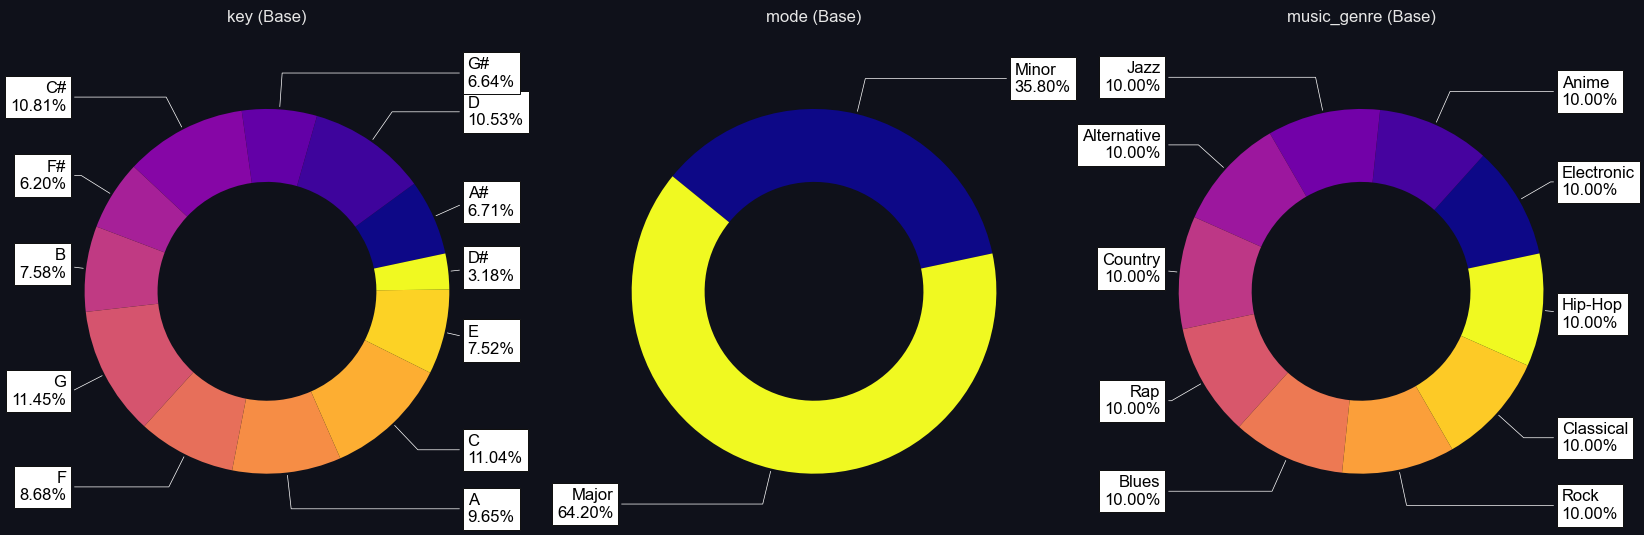

In [489]:
CateDonut, axes = plt.subplots(1, 3, figsize=(20,20))
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='w', lw=0.5),
          bbox=bbox_props, zorder=0, va="center")
for idx, col in enumerate(dfCate.columns):
    labelName = df[col].unique().tolist()
    wedges, texts = axes[idx].pie(df[col].value_counts(normalize=True)[df[col].unique()] * 100,
                                            startangle = 12,
                                            colors = pieCmap(np.linspace(0, 1, num=len(df[col].value_counts()))),
                                            wedgeprops=dict(width=0.4))
    axes[idx].set_title(col + " (Base)", pad=30)
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        axes[idx].annotate(f"{labelName[i]}\n{df[col].value_counts(normalize=True)[df[col].unique()][i]*100:.2f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)

## **Data Preprocessing**

### **Handle Missing Values**

Babababababa

In [ ]:
df_vis = df.copy()
df_impute =  df.copy()

In [ ]:
def plotForImpute(df, feature, df2 = None, prefix = ['','']):
    df = df.copy()
    df_Electronic = df[df['music_genre'] == 'Electronic']
    df_Anime = df[df['music_genre'] == 'Anime']
    df_Jazz = df[df['music_genre'] == 'Jazz']
    df_Alternative = df[df['music_genre'] == 'Alternative']
    df_Country = df[df['music_genre'] == 'Country']
    df_Blues = df[df['music_genre'] == 'Blues']
    df_Rap = df[df['music_genre'] == 'Rap']
    df_Rock = df[df['music_genre'] == 'Rock']
    df_Classical = df[df['music_genre'] == 'Classical']
    df_Hip_Hop = df[df['music_genre'] == 'Hip-Hop']
    if type(df2) == type(None):
        plotDflist = [df_Electronic, df_Anime, df_Jazz, df_Alternative, df_Country, df_Blues, df_Rap, df_Rock, df_Classical, df_Hip_Hop]
        titlelist = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Blues', 'Rap', 'Rock', 'Classical', 'Hip-Hop']
        row , col = 2, 5
        targetPlot = feature
        imputeHists, axes = plt.subplots(row, col, figsize=(30, 10))
    else :
        df2 = df2.copy()
        df2_Electronic = df2[df2['music_genre'] == 'Electronic']
        df2_Anime = df2[df2['music_genre'] == 'Anime']
        df2_Jazz = df2[df2['music_genre'] == 'Jazz']
        df2_Alternative = df2[df2['music_genre'] == 'Alternative']
        df2_Country = df2[df2['music_genre'] == 'Country']
        df2_Blues = df2[df2['music_genre'] == 'Blues']
        df2_Rap = df2[df2['music_genre'] == 'Rap']
        df2_Rock = df2[df2['music_genre'] == 'Rock']
        df2_Classical = df2[df2['music_genre'] == 'Classical']
        df2_Hip_Hop = df2[df2['music_genre'] == 'Hip-Hop']
        plotDflist = [df_Electronic, df2_Electronic, df_Anime, df2_Anime, df_Jazz, df2_Jazz, df_Alternative, df2_Alternative, df_Country, df2_Country, df_Blues, df2_Blues, df_Rap, df2_Rap, df_Rock, df2_Rock, df_Classical, df2_Classical, df_Hip_Hop, df2_Hip_Hop]
        titlelist = ['Electronic', 'Electronic', 'Anime', 'Anime', 'Jazz', 'Jazz', 'Alternative', 'Alternative', 'Country', 'Country', 'Blues', 'Blues', 'Rap', 'Rap', 'Rock', 'Rock', 'Classical', 'Classical', 'Hip-Hop', 'Hip-Hop']
        row , col = 5, 2
        targetPlot = feature
        imputeHists, axes = plt.subplots(2*row, col, figsize=(20, 60))
    for i, df in enumerate(plotDflist):
            ax = axes[i//col, i%col]
            sns.histplot(df[targetPlot], ax=ax, color=snsPalette[0], kde=True)
            if i%2 == 0:
                ax.set_title(f'{prefix[0]}'+titlelist[i])
            else:
                ax.set_title(f'{prefix[1]}'+titlelist[i])
            ax.set_xlabel(targetPlot)
            ax.set_ylabel('Count')
            ax.set_facecolor(axBGColor)
    return imputeHists

#### **Plotting Histogram**

In [ ]:
imputeHists_tempo = plotForImpute(df_vis, 'tempo')

In [ ]:
imputeHists_duration_ms = plotForImpute(df_vis, 'duration_ms')

bababababababa

#### **Imputation Using Mean,Most Frequent**

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_impute_mean = df_impute.copy()
df_impute_mean['tempo'] = imp_mean.fit_transform(df_impute_mean[['tempo']])
df_impute_mean['duration_ms'] = imp_mean.fit_transform(df_impute_mean[['duration_ms']])
imputeHists_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mean, ['Original ','Imputed '])
imputeHists_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mean, ['Original ','Imputed '])

In [ ]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_impute_mode = df_impute.copy()
df_impute_mode['tempo'] = imp_mode.fit_transform(df_impute_mode[['tempo']])
df_impute_mode['duration_ms'] = imp_mode.fit_transform(df_impute_mode[['duration_ms']])
imputeHists_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mode, ['Original ','Imputed '])
imputeHists_duration_ms_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mode, ['Original ','Imputed '])

bababababababa

#### **Imputation Using Multivariate Imputation by Chained Equations(mice)**

In [ ]:
from impyute.imputation.cs import mice

df_impute_mice = df_impute.copy()
df_impute_mice.drop(['music_genre','key','mode'], axis=1, inplace=True)
imputed_training=mice(df_impute_mice.values)

In [ ]:
df_impute_mice = pd.DataFrame(imputed_training, columns=df_impute_mice.columns)
df_impute_mice['key'] = df_impute['key']
df_impute_mice['mode'] = df_impute['mode']
df_impute_mice['music_genre'] = df_impute['music_genre']
df_impute_mice

In [ ]:
imputeHists_tempo_compare = plotForImpute(df_vis , 'tempo', df_impute_mice, ['Original ','Imputed '])

In [ ]:
imputeHists_tempo_compare = plotForImpute(df_vis , 'duration_ms', df_impute_mice, ['Original ','Imputed '])

bababababababababababa

#### **Imputation Using KNNImputer**

In [ ]:
# # Impute missing values
# # Cant use KNNImputer as it unable to allocate memory for an array with shape (2684, 50000) and data type float64
# imputer = KNNImputer(n_neighbors=11)
# df_tempo_impute['tempo'] = imputer.fit_transform(df_tempo_impute[['tempo']])
# df_tempo_impute

bababababababaa cant use

#### **Conclusion**

babababababababababababababa

To conclude everything up to this point, there were <u>4 unnecessary feature</u>, <u>4 duplicated instances</u> and <u>1 missing values</u> that we have removed. This means that we are left with a total of **50000 instances and 14 features**.

In which, there are:

- 4 features, including output, that are '<font color='green'>object</font>', which means that they are '<font color='red'>Categorical Features</font>'.
- 10 features that are '<font color='green'>int64</font>', which means that they are '<font color='red'>Numerical Features</font>'